First, we need to download kaggle dataset to google colab (what we will do below)

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ulugbekshernazarov","key":"0226582af8e72e91a2cb63c50c66ac82"}'}

In [3]:
ls

kaggle.json  sample_data/


In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d gti-upm/leapgestrecog

 99% 2.11G/2.13G [00:13<00:00, 140MB/s]
100% 2.13G/2.13G [00:14<00:00, 163MB/s]


In [9]:
!mkdir handrec

In [10]:
! unzip leapgestrecog.zip -d handrec

Streaming output truncated to the last 5000 lines.
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: handrec/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: handrec/leap

We successfully downloaded the dataset from kaggle (Hand Gesture Recognition Database)
Next, let's import required packages to manipulate, build a model, and make training.

We will use Keras on Tensorflow back

In [26]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np
import keras.backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.datasets import make_multilabel_classification
# Import of keras model and hidden layers for our convolutional network
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

In [27]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "./handrec/leapGestRecog"

In [28]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[3, 6, 6, ..., 4, 5, 4],
        [5, 5, 7, ..., 5, 5, 5],
        [6, 6, 6, ..., 4, 4, 5],
        ...,
        [5, 6, 5, ..., 5, 5, 5],
        [4, 5, 5, ..., 5, 5, 5],
        [4, 6, 5, ..., 3, 7, 4]], dtype=uint8), 0]

In [29]:
# shuffle the input data

import random
random.shuffle(image_data)

Now that we loaded the images and checked if it's everything we expected, we have to prepare the images to train the algorithm. We have to load all the images into an array that we will call X and all the labels into another array called y.

In [30]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)
input_data[:5]

[array([[4, 5, 5, ..., 7, 6, 7],
        [5, 5, 5, ..., 7, 7, 7],
        [5, 5, 5, ..., 7, 6, 7],
        ...,
        [4, 4, 5, ..., 8, 7, 6],
        [5, 4, 5, ..., 7, 7, 6],
        [4, 4, 5, ..., 7, 6, 7]], dtype=uint8), array([[5, 4, 4, ..., 3, 3, 3],
        [5, 4, 5, ..., 3, 4, 4],
        [5, 5, 5, ..., 4, 4, 5],
        ...,
        [4, 6, 5, ..., 4, 4, 4],
        [5, 5, 5, ..., 4, 4, 5],
        [6, 4, 4, ..., 3, 4, 5]], dtype=uint8), array([[3, 5, 5, ..., 4, 4, 3],
        [5, 5, 5, ..., 3, 4, 4],
        [6, 5, 5, ..., 3, 4, 3],
        ...,
        [4, 4, 5, ..., 3, 4, 2],
        [4, 4, 3, ..., 3, 3, 3],
        [4, 3, 3, ..., 2, 3, 4]], dtype=uint8), array([[4, 4, 4, ..., 4, 3, 3],
        [4, 5, 5, ..., 3, 4, 3],
        [5, 5, 6, ..., 4, 4, 3],
        ...,
        [4, 5, 5, ..., 5, 4, 5],
        [4, 6, 5, ..., 3, 4, 3],
        [5, 5, 6, ..., 5, 5, 5]], dtype=uint8), array([[5, 5, 5, ..., 5, 4, 4],
        [6, 5, 6, ..., 4, 4, 4],
        [6, 5, 5, ..., 4, 4, 4],
 

In [31]:
label[:10]

[4, 5, 9, 7, 1, 4, 7, 5, 5, 6]

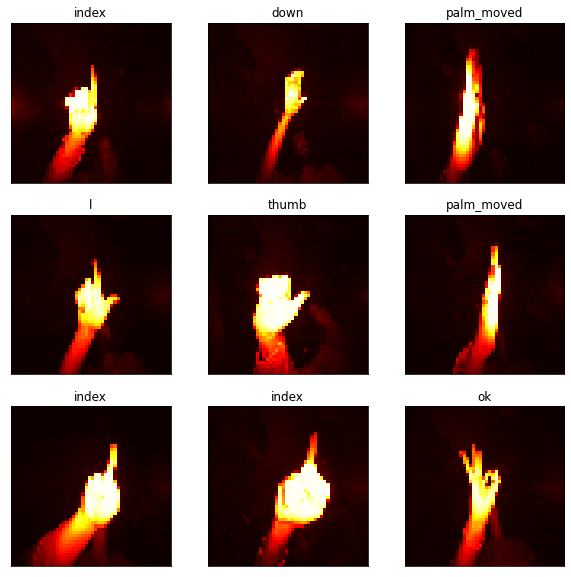

In [32]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [33]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [34]:
from sklearn.datasets import make_multilabel_classification
X,y=make_multilabel_classification(n_samples=500,n_features=4,n_classes=2,n_labels=3,random_state=1)
X

array([[ 9., 12.,  6., 12.],
       [ 5.,  2., 12., 22.],
       [15.,  5., 12., 11.],
       ...,
       [ 5., 10., 15., 28.],
       [ 0.,  8., 16., 27.],
       [ 6.,  9., 13., 22.]])

In [35]:
y

array([[0, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1,

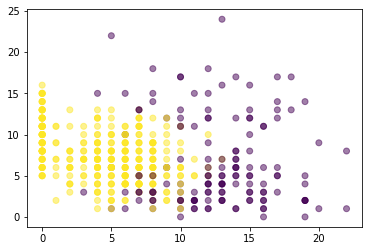

In [37]:
rng=np.random.RandomState(1)
colors=rng.rand(1000)
plt.scatter(X[:,0:1],X[:,1:2],c=y[:,0],alpha=0.5,cmap='viridis')
plt.show()

In [38]:
X=(X-X.min())/(X.max()-X.min())
X

array([[0.20454545, 0.27272727, 0.13636364, 0.27272727],
       [0.11363636, 0.04545455, 0.27272727, 0.5       ],
       [0.34090909, 0.11363636, 0.27272727, 0.25      ],
       ...,
       [0.11363636, 0.22727273, 0.34090909, 0.63636364],
       [0.        , 0.18181818, 0.36363636, 0.61363636],
       [0.13636364, 0.20454545, 0.29545455, 0.5       ]])

In [39]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int8)

In [40]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [41]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.10, random_state=0)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((18000, 50, 50, 1), (18000, 10), (2000, 50, 50, 1), (2000, 10))

In [43]:
#Here we created layers for our network
network = keras.models.Sequential()

network.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
network.add(Activation('relu'))

network.add(Conv2D(filters = 32, kernel_size = (3,3)))
network.add(Activation('relu'))
network.add(MaxPool2D(pool_size=(2,2)))
network.add(Dropout(0.3))

network.add(Conv2D(filters = 64, kernel_size = (3,3)))
network.add(Activation('relu'))
network.add(MaxPool2D(pool_size=(2,2)))
network.add(Dropout(0.3))

network.add(Flatten())
network.add(Dense(256, activation='relu'))
network.add(Dense(10, activation='softmax'))

network.compile(loss='categorical_crossentropy',
         optimizer = 'rmsprop',
         metrics = ['accuracy'])

In [44]:
network.fit(X_train, y_train, epochs = 6, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/6
563/563 [==============================] - 158s 279ms/step - loss: 0.2664 - accuracy: 0.9136 - val_loss: 0.0214 - val_accuracy: 0.9945
Epoch 2/6
563/563 [==============================] - 151s 269ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 3/6
563/563 [==============================] - 151s 268ms/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 5.6375e-04 - val_accuracy: 0.9995
Epoch 4/6
563/563 [==============================] - 151s 268ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0067 - val_accuracy: 0.9980
Epoch 5/6
563/563 [==============================] - 153s 273ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 4.7917e-04 - val_accuracy: 0.9995
Epoch 6/6
563/563 [==============================] - 151s 269ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0035 - val_accuracy: 0.9990


In [45]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_3 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_4 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 23, 23, 32)        0         
                                                      

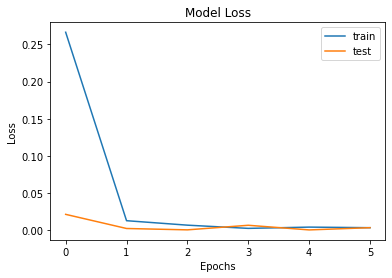

In [52]:
plt.plot(network.history.history['loss'])
plt.plot(network.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig('epoch.png')

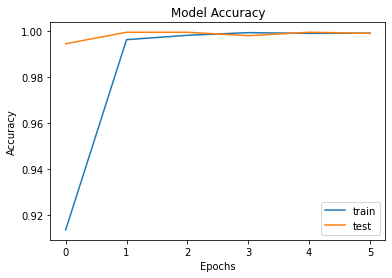

In [51]:
plt.plot(network.history.history['accuracy'])
plt.plot(network.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig('acc.png')

In [59]:
test_loss, test_accuracy = network.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

63/63 [==============================] - 4s 60ms/step - loss: 0.0035 - accuracy: 0.9990
Test accuracy: 99.90%


63/63 [==============================] - 5s 73ms/step


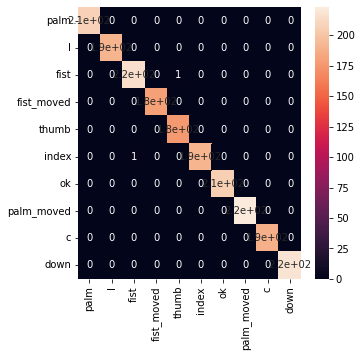

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in CATEGORIES]
plt.figure(figsize=(5,5))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(network.predict(X_test), axis=1))
sn.heatmap(cm, annot=True,xticklabels=cat, yticklabels=cat)
plt.savefig('conf_mat.png')